# Prepare the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split

In [2]:
credits = pd.read_csv('/Users/xhan/OneDrive/dataset/tmdb-5000-movie-dataset/tmdb_5000_credits.csv')
movies = pd.read_csv('/Users/xhan/OneDrive/dataset/tmdb-5000-movie-dataset/tmdb_5000_movies_nonull.csv')

In [3]:
movies_sub = movies.loc[:, ['id', 'original_title', 'genres']]
credits_sub = credits.loc[:, ['movie_id', 'cast']].rename(columns={'movie_id':'id'})
df = movies_sub.merge(credits_sub)

In [4]:
def extract_gender(cell):
    """Extract cast gender"""
    female = 0
    male = 0
    for item in json.loads(cell):
        if item['gender'] == 1: female += 1
        else: male += 1
            
    return female, male

In [5]:
def modify_df(cell):
    """Convert string-format json cell to list"""
    my_list = []
    for item in json.loads(cell):
        my_list.append(item['name'])
 
    return my_list

In [6]:
def concat_names(cell):
    """Concatenate first names and last names"""
    names = []
    for name in cell:
        names.append(name.replace(' ', ''))
    return names

In [7]:
df.head(5)

,id,original_title,genres,cast
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,49026,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,49529,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


In [8]:
# drop movies with no cast/genre info
for i, row in df.iterrows():
    if row['cast'] == '[]' or row['genres'] == '[]':
        df.drop(i, inplace=True)
    #df1.at[i, 'cast_list'] = ' '.join(row['cast_list'])

In [9]:
df = df.dropna()
df.head(5)

,id,original_title,genres,cast
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,49026,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,49529,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


In [10]:
for col_name in ['genres', 'cast']:
    if col_name == 'cast':
        gen = df[col_name].apply(extract_gender)
        df['female_pct'] = gen.apply(lambda x: x[0]/(x[0]+x[1]))
        df['male_pct'] = gen.apply(lambda x: x[1]/(x[0]+x[1]))
    
    df[col_name] = df[col_name].apply(modify_df)

In [11]:
df.head(5)

,id,original_title,genres,cast,female_pct,male_pct
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[Sam Worthington, Zoe Saldana, Sigourney Weave...",0.144578,0.855422
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[Johnny Depp, Orlando Bloom, Keira Knightley, ...",0.147059,0.852941
2,206647,Spectre,"[Action, Adventure, Crime]","[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",0.156627,0.843373
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[Christian Bale, Michael Caine, Gary Oldman, A...",0.069620,0.930380
4,49529,John Carter,"[Action, Adventure, Science Fiction]","[Taylor Kitsch, Lynn Collins, Samantha Morton,...",0.222222,0.777778


In [12]:
df['cast'] = df['cast'].apply(concat_names)

In [13]:
df.head(5)

,id,original_title,genres,cast,female_pct,male_pct
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[SamWorthington, ZoeSaldana, SigourneyWeaver, ...",0.144578,0.855422
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[JohnnyDepp, OrlandoBloom, KeiraKnightley, Ste...",0.147059,0.852941
2,206647,Spectre,"[Action, Adventure, Crime]","[DanielCraig, ChristophWaltz, LéaSeydoux, Ralp...",0.156627,0.843373
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[ChristianBale, MichaelCaine, GaryOldman, Anne...",0.069620,0.930380
4,49529,John Carter,"[Action, Adventure, Science Fiction]","[TaylorKitsch, LynnCollins, SamanthaMorton, Wi...",0.222222,0.777778


### Delete cast with less than three movies

In [14]:
# All cast: # of movies
cast_all = defaultdict(int)

for names in df.cast:
    for p in names:
        cast_all[p] += 1

sorted(cast_all.items(), key=lambda x: x[1], reverse=True)[:5]

[('SamuelL.Jackson', 67),
 ('RobertDeNiro', 57),
 ('BruceWillis', 51),
 ('MattDamon', 48),
 ('MorganFreeman', 46)]

In [15]:
# actors/actresses who have less than three movies
cast_remove = [key for (key, value) in cast_all.items() if value <= 2]

In [16]:
# drop cast who have less than three movies
for i, row in df.iterrows():
    df.at[i, 'cast'] = list(set(row.cast) - set(cast_remove))
#     for j, name in enumerate(row.cast_list):
#         row['cast_list'][j] = name.replace(' ', '')

In [17]:
df.head(5)

,id,original_title,genres,cast,female_pct,male_pct
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[JoelDavidMoore, JahnelCurfman, KevinDorman, A...",0.144578,0.855422
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[KeiraKnightley, AndyBeckwith, ReggieLee, Vane...",0.147059,0.852941
2,206647,Spectre,"[Action, Adventure, Crime]","[AndrewScott, IanBonar, LéaSeydoux, NaomieHarr...",0.156627,0.843373
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[ReggieLee, FredricLehne, AlexMoore, JosephO'B...",0.069620,0.930380
4,49529,John Carter,"[Action, Adventure, Science Fiction]","[TaylorKitsch, LynnCollins, PollyWalker, James...",0.222222,0.777778


### Genres Overview

In [18]:
all_genres = defaultdict(int)

for row in df.genres:
    for item in row:
        all_genres[item] += 1

all_genres

defaultdict(int,
            {'Action': 1152,
             'Adventure': 790,
             'Fantasy': 424,
             'Science Fiction': 534,
             'Crime': 695,
             'Drama': 2292,
             'Thriller': 1272,
             'Animation': 234,
             'Family': 510,
             'Western': 82,
             'Comedy': 1719,
             'Romance': 893,
             'Horror': 519,
             'Mystery': 347,
             'History': 197,
             'War': 144,
             'Music': 184,
             'Documentary': 91,
             'Foreign': 33,
             'TV Movie': 8})

In [19]:
genres_list = sorted(all_genres.items(), key=lambda x: x[1], reverse=True)
genres_list

[('Drama', 2292),
 ('Comedy', 1719),
 ('Thriller', 1272),
 ('Action', 1152),
 ('Romance', 893),
 ('Adventure', 790),
 ('Crime', 695),
 ('Science Fiction', 534),
 ('Horror', 519),
 ('Family', 510),
 ('Fantasy', 424),
 ('Mystery', 347),
 ('Animation', 234),
 ('History', 197),
 ('Music', 184),
 ('War', 144),
 ('Documentary', 91),
 ('Western', 82),
 ('Foreign', 33),
 ('TV Movie', 8)]

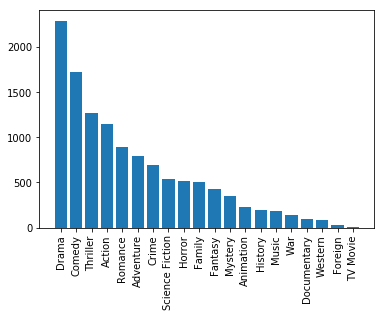

In [20]:
plt.bar(x = [x[0] for x in genres_list], height = [y[1] for y in genres_list])
plt.xticks(rotation=90)
plt.show()

## Pairwise analysis of Movie Genres


Put highly dependent labels into the same cluster, so that we can assume the four resulting clusters are approximately independent.


*Source: https://spandan-madan.github.io/DeepLearningProject/*

In [21]:
import itertools

# This function just generates all possible pairs of movies
def list2pairs(genres):
    # itertools.combinations(l,2) makes all pairs of length 2 from list l.
    pairs = list(itertools.combinations(genres, 2))
    # then the one item pairs, as duplicate pairs aren't accounted for by itertools
    for genre in genres:
        pairs.append([genre, genre])
    return pairs

In [22]:
# get all genre lists pairs from all movies
allPairs = []
for cell in df.genres:
    allPairs.extend(list2pairs(cell))
    
nr_ids = np.unique(allPairs)
visGrid = np.zeros((len(nr_ids), len(nr_ids)))
for p in allPairs:
    visGrid[np.argwhere(nr_ids==p[0]), np.argwhere(nr_ids==p[1])]+=1
    if p[1] != p[0]:
        visGrid[np.argwhere(nr_ids==p[1]), np.argwhere(nr_ids==p[0])]+=1

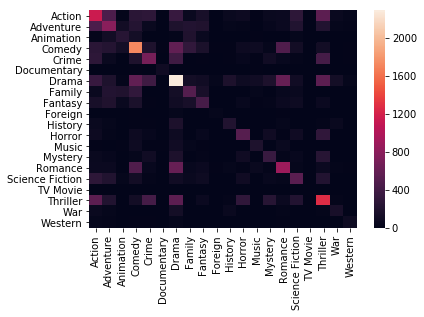

In [23]:
import seaborn as sns

# shows how often the genres occur together
annot_lookup = []
for i in range(len(nr_ids)):
    annot_lookup.append(nr_ids[i])

sns.heatmap(visGrid, xticklabels=annot_lookup, yticklabels=annot_lookup)

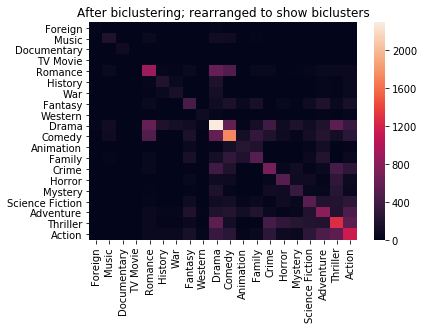

In [24]:
# co-cluster the genres
# n_clusters=4 has the best result
from sklearn.cluster import SpectralCoclustering

model = SpectralCoclustering(n_clusters=4, svd_method='arpack', random_state=0)
model.fit(visGrid)

fit_data = visGrid[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

annot_lookup_sorted = []
for i in np.argsort(model.row_labels_):
    annot_lookup_sorted.append(nr_ids[i])
    
sns.heatmap(fit_data, xticklabels=annot_lookup_sorted, yticklabels=annot_lookup_sorted, annot=False)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()

**Four clusters:**  
+ **Exciting**: Thriller, Horror, Action, Adventure, Sci-Fi, Crime, Mystery, Fantasy    
+ **Uplifting**: Drama, Romance, Comedy, Family  
+ **Reality:** Documentary, War, History, Foreign, Music
+ **Others:** Western, TV Movie, Animation

## Change genres to four new subsets

In [ ]:
new_genres = []

for i, cell in enumerate(df.genres):
    cell_genre = []
    for item in cell:
        if item in ['Thriller', 'Horror', 'Action', 'Adventure', 'Science Fiction', 'Crime', 'Mystery', 'Fantasy']:
            cell_genre.append('Exciting')
        elif item in ['Drama', 'Romance', 'Comedy', 'Family']:
            cell_genre.append('Uplifting')
        elif item in ['Documentary', 'War', 'History', 'Foreign', 'Music']:
            cell_genre.append('Reality')
        else:
            cell_genre.append('Others')
    new_genres.append(list(set(cell_genre)))

df['genres'] = new_genres

## Cast vs. Genres

In [25]:
for i, row in df.iterrows():
    df.at[i, 'cast'] = ' '.join(row['cast'])

### One-vs-Rest

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [27]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, hamming_loss
from sklearn.metrics import roc_auc_score

In [28]:
# One-Hot encoding
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit_transform(df.genres)
train_data, test_data, train_labels, test_labels = train_test_split(df.iloc[:, 3], mlb.transform(df.genres),
                                                                    test_size=0.2, random_state=0)

In [29]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
train_cast_vect = vectorizer.fit_transform(train_data)
test_cast_vect = vectorizer.transform(test_data)

# train_features = np.concatenate((train_cast_vect.todense(), np.asmatrix(train_data.iloc[:, 1:])), axis=1)
# test_features = np.concatenate((test_cast_vect.todense(), np.asmatrix(test_data.iloc[:, 1:])), axis=1)

In [30]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

parameters = {'alpha':10**np.linspace(-1, 1, 10), 
              'fit_prior':[True, False]}
# gridCV = GridSearchCV(SVC(class_weight='balanced'), parameters, 
gridCV = GridSearchCV(MultinomialNB(), parameters, 
                      scoring=make_scorer(f1_score, average='micro'), cv=5)
clf = OneVsRestClassifier(gridCV)

clf.fit(train_cast_vect, train_labels)
y_score = clf.fit(train_cast_vect, train_labels).predict_proba(test_cast_vect)
predicted = clf.predict(test_cast_vect)

In [31]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted, target_names=mlb.classes_))

                 precision    recall  f1-score   support

         Action       0.83      0.19      0.31       227
      Adventure       0.93      0.09      0.16       155
      Animation       1.00      0.16      0.27        45
         Comedy       0.82      0.63      0.71       342
          Crime       0.00      0.00      0.00       154
    Documentary       1.00      0.10      0.18        20
          Drama       0.75      0.64      0.69       476
         Family       1.00      0.10      0.19        96
        Fantasy       1.00      0.04      0.08        91
        Foreign       0.00      0.00      0.00         4
        History       0.00      0.00      0.00        40
         Horror       1.00      0.02      0.04       103
          Music       0.50      0.03      0.05        37
        Mystery       0.00      0.00      0.00        68
        Romance       0.67      0.01      0.02       195
Science Fiction       1.00      0.03      0.05       120
       TV Movie       0.00    

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', ave

In [32]:
accuracy = accuracy_score(y_pred=predicted, y_true=np.array(test_labels))
f1 = f1_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')
precision = precision_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')
recall = recall_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')

print("Accuracy: {}".format(accuracy)) # subset accuracy
print("F1 score: {}".format(f1))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Accuracy: 0.09578947368421052
F1 score: 0.38025594149908587
Precision: 0.7868852459016393
Recall: 0.2507030936118923


In [33]:
for i in range(predicted.shape[1]):
    print('{}: {}'.format(mlb.classes_[i], 
                          accuracy_score(np.asarray(test_labels)[:, i], np.asarray(predicted)[:, i])))

Action: 0.7968421052631579
Adventure: 0.8505263157894737
Animation: 0.96
Comedy: 0.8147368421052632
Crime: 0.8378947368421052
Documentary: 0.9810526315789474
Drama: 0.7105263157894737
Family: 0.9094736842105263
Fantasy: 0.9084210526315789
Foreign: 0.9957894736842106
History: 0.9578947368421052
Horror: 0.8936842105263157
Music: 0.9610526315789474
Mystery: 0.9284210526315789
Romance: 0.7957894736842105
Science Fiction: 0.8768421052631579
TV Movie: 0.9978947368421053
Thriller: 0.7273684210526316
War: 0.9705263157894737
Western: 0.9842105263157894


In [45]:
for i in range(len(predicted)):
    print(predicted[i], test_labels[i])

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0] [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0

In [39]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(mlb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

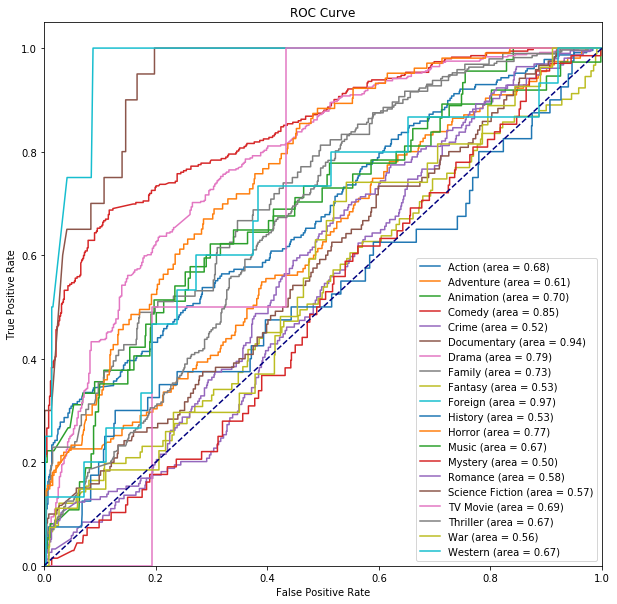

In [41]:
plt.figure(figsize=(10, 10))
for i in range(len(mlb.classes_)):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(mlb.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [36]:
mlb.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [37]:
# for d in zip(predicted, np.array(test_labels)):
#     print('Predicted:{}, ground truth:{}'.format(d[0], d[1]))